## Time Series Project

1. Explore the electricity dataset, using tools like line charts and decomposition
2. Forecast the first three days of February 2017 (72 hours) of electricity consumption for column `PowerConsumption_Zone1`, using the entire month of January 2017 to train your Model.
3. Fit both a Linear Regression model and Facebook Prophet. Compare their accuracy using plots of predicted vs. actual, as well as metrics like MAE and MAPE


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm

electricity_df = pd.read_csv(
    "./Data/powerconsumption.csv", 
    index_col=["Datetime"],
    parse_dates=["Datetime"]
).resample("H").mean()

In [2]:
electricity_df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-01-01 00:00:00,6.196833,75.066667,0.081833,0.063500,0.098833,29197.974683,18026.747720,19252.048193
2017-01-01 01:00:00,5.548833,77.583333,0.082000,0.056833,0.112500,24657.215190,16078.419453,17042.891567
2017-01-01 02:00:00,5.054333,78.933333,0.082333,0.063000,0.129167,22083.037973,14330.699088,15676.144578
2017-01-01 03:00:00,5.004333,77.083333,0.082833,0.059833,0.141000,20811.139240,13219.452887,14883.855422
2017-01-01 04:00:00,5.097667,74.050000,0.082333,0.058000,0.122833,20475.949367,12921.580547,14317.108433


<Axes: xlabel='Datetime'>

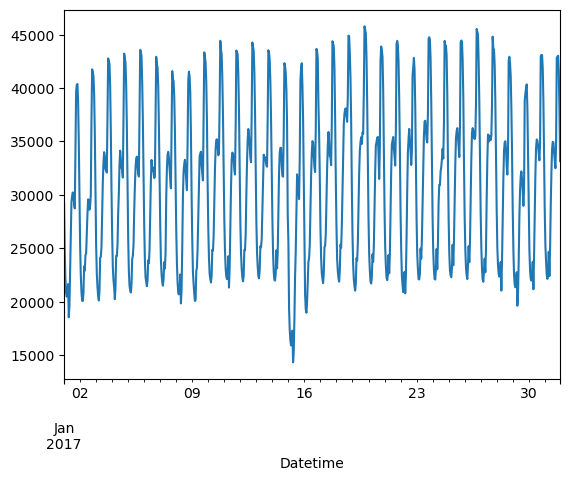

In [5]:
# 744 hours = 31 days [:744]
electricity_df["PowerConsumption_Zone1"].iloc[:744].plot()

# each hour of the day has a different seasonal average

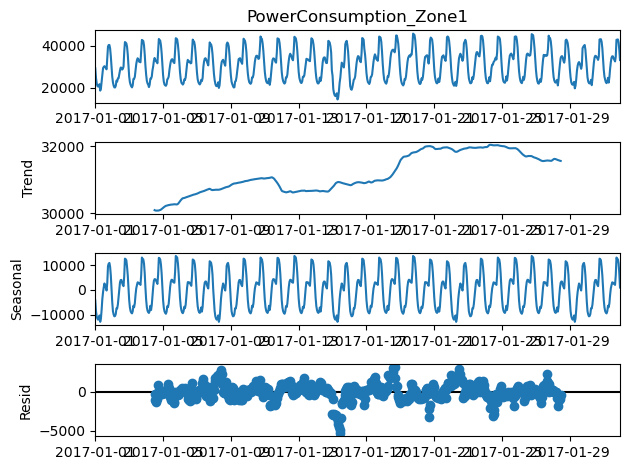

In [7]:
# Decompose the dataframe
from statsmodels.tsa.seasonal import seasonal_decompose

results = seasonal_decompose(electricity_df["PowerConsumption_Zone1"].iloc[:744], period=(24 * 7))

results.plot();

# We can see overall trend when seasonality is removed
# Notice dip around 15JAN
# Residuals appear to be random noise

## Linear Regression

In [26]:
# Focus on PowerConsumption_Zone1
electricity_df = electricity_df["PowerConsumption_Zone1"].reset_index()

electricity_df = electricity_df.assign(
    trend = electricity_df.index,
    hour = electricity_df["Datetime"].dt.hour.astype("string"),
#     day_of_week = electricity_df["Datetime"].dt.dayofweek.astype("string"),
).set_index("Datetime")

electricity_df = pd.get_dummies(electricity_df, drop_first=True)

electricity_df.head()

# Get Reference level by running code below
# electricity_df.info()
# Hour_0 has been dropped so midnight is reference level

,PowerConsumption_Zone1,trend,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,hour_16,...,hour_21,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,29197.974683,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 01:00:00,24657.215190,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 02:00:00,22083.037973,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-01-01 03:00:00,20811.139240,3,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2017-01-01 04:00:00,20475.949367,4,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [27]:
# Split train and test 
electricity_train = electricity_df.loc[:"2017-01-31"]
electricity_test = electricity_df.loc["2017-02-01": "2017-02-03"]

# Prepare the training data
X_train = sm.add_constant(electricity_train.drop("PowerConsumption_Zone1", axis=1))
y_train = electricity_train["PowerConsumption_Zone1"]

# Prepare the testing data
X_test = sm.add_constant(electricity_test.drop("PowerConsumption_Zone1", axis=1))
y_test = electricity_test["PowerConsumption_Zone1"]

In [28]:
import statsmodels.api as sm

model = sm.OLS(y_train, X_train).fit()
model.summary()

# Through the month of JAN electricity usage is increasing by 2.8 Kw / HR

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     PowerConsumption_Zone1   R-squared:                       0.951
Model:                                OLS   Adj. R-squared:                  0.949
Method:                     Least Squares   F-statistic:                     577.4
Date:                    Wed, 06 Sep 2023   Prob (F-statistic):               0.00
Time:                            21:08:28   Log-Likelihood:                -6558.4
No. Observations:                     744   AIC:                         1.317e+04
Df Residuals:                         719   BIC:                         1.328e+04
Df Model:                              24                                         
Covariance Type:                nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.634e+04    314.697     83.687      0.000    2.57e+04     2.7e+04
trend          2.7642      0.283      9.763      0.000       2.208       3.320
hour_1     -3371.1268    421.061     -8.006      0.000   -4197.783   -2544.471
hour_10     3722.1664    421.070      8.840      0.000    2895.492    4548.841
hour_11     5958.7162    421.072     14.151      0.000    5132.038    6785.394
hour_12     6754.9721    421.075     16.042      0.000    5928.290    7581.655
hour_13     6920.6359    421.077     16.436      0.000    6093.949    7747.323
hour_14     6197.7084    421.079     14.719      0.000    5371.016    7024.401
hour_15     5565.0054    421.082     13.216      0.000    4738.308    6391.703
hour_16     5048.1049    421.085     11.988      0.000    4221.401    5874.808
hour_17     8939.2729    421.088     21.229      0.000    8112.563    9765.983
hour_18      1.57e+04    421.092     37.293      0.000    1.49e+04    1.65e+04
hour_19     1.567e+04    421.095     37.206      0.000    1.48e+04    1.65e+04
hour_2     -5008.9746    421.061    -11.896      0.000   -5835.631   -4182.318
hour_20     1.541e+04    421.099     36.587      0.000    1.46e+04    1.62e+04
hour_21     1.365e+04    421.103     32.405      0.000    1.28e+04    1.45e+04
hour_22     1.012e+04    421.107     24.041      0.000    9297.105     1.1e+04
hour_23     4757.7226    421.111     11.298      0.000    3930.968    5584.477
hour_3     -5816.3121    421.062    -13.813      0.000   -6642.969   -4989.655
hour_4     -6086.6794    421.062    -14.456      0.000   -6913.338   -5260.021
hour_5     -5378.3288    421.063    -12.773      0.000   -6204.989   -4551.669
hour_6     -3451.3910    421.064     -8.197      0.000   -4278.053   -2624.729
hour_7     -4639.4880    421.065    -11.018      0.000   -5466.153   -3812.823
hour_8     -3015.4331    421.067     -7.161      0.000   -3842.101   -2188.765
hour_9       422.0968    421.069      1.002      0.316    -404.574    1248.768
==============================================================================
Omnibus:                      300.491   Durbin-Watson:                   0.188
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1597.209
Skew:                          -1.762   Prob(JB):                         0.00
Kurtosis:                       9.254   Cond. No.                     1.05e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.05e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape

print(f"MAE: {mae(y_test, model.predict(X_test))}")
print(f"MAPE: {mape(y_test, model.predict(X_test))}")

MAE: 1016.8138495938268
MAPE: 0.03272545074532686


<Axes: xlabel='Datetime'>

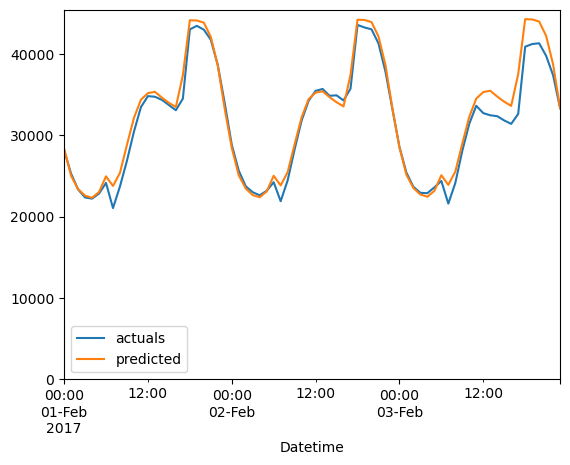

In [30]:
test_preds = pd.DataFrame({
    "actuals": y_test.values, 
    "predicted": model.predict(X_test)
})

test_preds.plot(ylim=0)

## Facebook Prophet

In [34]:
from prophet import Prophet

# electricity_df is your existing DataFrame
electricity_prophet = (
    electricity_df
    .reset_index()  # Reset the index of electricity_df
    .rename(columns={"Datetime": "ds", "PowerConsumption_Zone1": "y"})  # Rename columns
)

In [35]:
# Create the training set by querying the dataset
electricity_train = electricity_prophet.query("ds < '2017-02-01'")   
# Create the test set by querying the dataset
electricity_test = electricity_prophet.query("'2017-02-01' <= ds < '2017-02-04'")

In [36]:
electricity_test.tail() 

,ds,y,trend,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,hour_15,...,hour_21,hour_22,hour_23,hour_3,hour_4,hour_5,hour_6,hour_7,hour_8,hour_9
811,2017-02-03 19:00:00,41218.983052,811,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
812,2017-02-03 20:00:00,41316.610170,812,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
813,2017-02-03 21:00:00,39773.898305,813,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
814,2017-02-03 22:00:00,37381.016948,814,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
815,2017-02-03 23:00:00,33327.457627,815,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [37]:
# Fit Model
model = Prophet()
model.fit(electricity_train[["ds", "y"]])

21:12:06 - cmdstanpy - INFO - Chain [1] start processing
21:12:06 - cmdstanpy - INFO - Chain [1] done processing


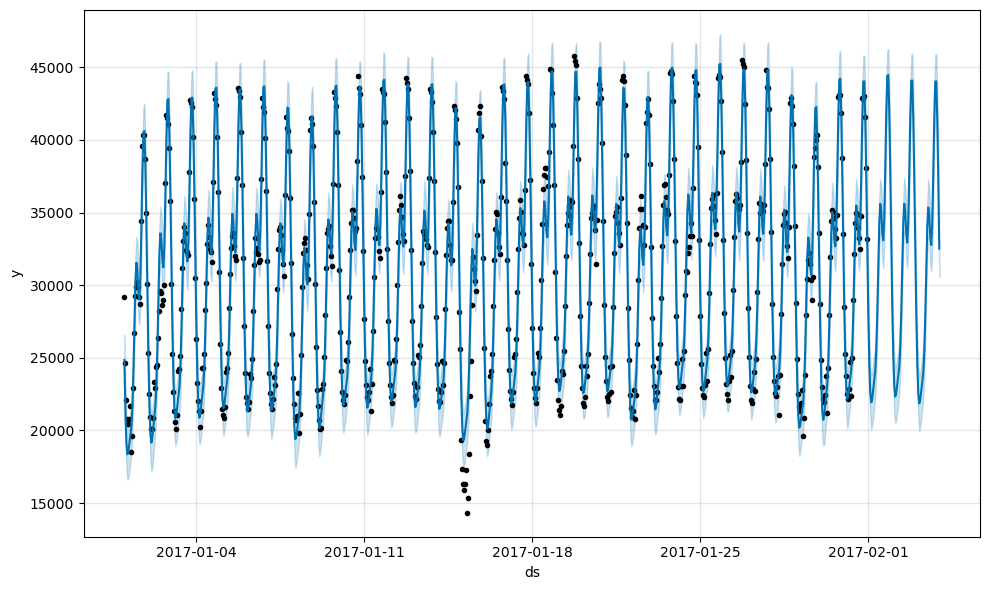

In [40]:
# Predict 72 hours in the future using freq="H"
future = model.make_future_dataframe(periods=72, freq="H")

forecast = model.predict(future)

model.plot(forecast);

# Overall prophet seems to align with the datapoints accurately
# Looks like forecast will be good

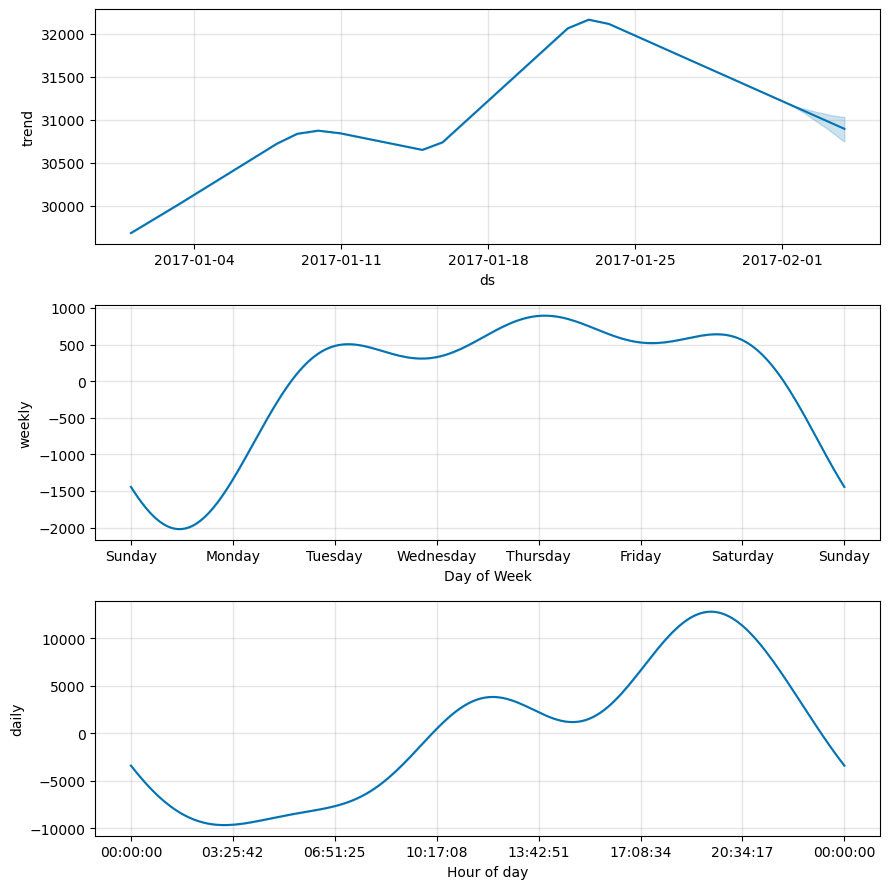

In [44]:
model.plot_components(forecast);

# Takeaway is the daily, hourly plot that shows what EDA showed
# Power consumption rises throughout the day and peaks in the evening when folks get home from work

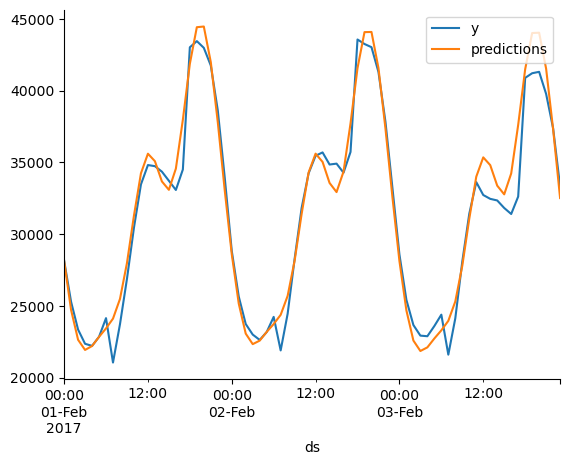

In [42]:
electricity_score = (
electricity_test
 .assign(predictions = model.predict(future)["yhat"])
 .set_index("ds")
 .loc[:,["y", "predictions"]]
)

electricity_score.plot()

sns.despine()

In [43]:
print(f"MAE: {mae(electricity_score['y'], electricity_score['predictions'])}")
print(f"MAPE: {mape(electricity_score['y'], electricity_score['predictions'])}")

MAE: 1048.3071662471777
MAPE: 0.03445346850361281


Both Linear Regression and Prohet performed well. Models can be performed quickly with accuracy.  